In [1]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cd ..

/home/anton/rurec


In [97]:
excluded_states = {'AK', 'PR', 'HI', 'VI'}
frac_fai_bins = [-0.01, 0.1, 0.3, 1]
frac_fai_labels = ['0 - 10%', '10 - 30%', '30 - 100%']
frac_fai_colors = ['purple', 'green', 'yellow']
area_style = {'color': 'brown', 'alpha': 0.3}

# Download geographic boundaries data
Census [Cartographic Boundary Shapefiles](https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html)

In [3]:
%%bash
OPWD=`pwd`
for ENTITY in csa cbsa; do
    FILE=cb_2017_us_${ENTITY}_500k.zip
    URL=https://www2.census.gov/geo/tiger/GENZ2017/shp/$FILE
    DIR=data/$ENTITY
    mkdir --parents $DIR
    cd $DIR
    wget --no-clobber --quiet $URL
    7z x $FILE > /dev/null
    cd $OPWD
    echo $FILE done.
done

cb_2017_us_csa_500k.zip done.
cb_2017_us_cbsa_500k.zip done.


# Employment data - InfoGroup

## Query and download raw data

In [ ]:
query = '''
SELECT
  state,
  substr(naics, 1, 6) as naics,
  employees,
  latitude,
  longitude
FROM
  `original.data`
where year = 2015;
'''
df = pd.read_gbq(query, dialect='standard', project_id='info-group-162919')
df.to_pickle('data/ig_2015.gz')

In [4]:
df = pd.read_pickle('data/ig_2015.gz')
df = df[~df.state.isin(excluded_states)]
df = df.drop('state', axis=1)
df.employees = pd.to_numeric(df.employees)
df = df.dropna(subset=['employees'])

## Identify non-farming FAI establishments

In [5]:
with open('data/fai.json') as f:
    fai_codes = json.load(f)
fainf_codes = {c: d for c, d in fai_codes.items() if c[:3] not in {'111', '112', '113', '114'}}
df['fai'] = df.naics.isin(fainf_codes)

In [6]:
pt = df.pivot_table('employees', 'fai', aggfunc=[pd.np.sum, pd.np.count_nonzero])
pt

,sum,count_nonzero
,employees,employees
fai,,
False,153966368.0,14076681.0
True,6759691.0,580999.0


In [7]:
pt / pt.sum()

,sum,count_nonzero
,employees,employees
fai,,
False,0.957943,0.960362
True,0.042057,0.039638


## Aggregate establishments into geographic bins for plotting

In [8]:
def expand_interval(df, col):
    for n in ['left', 'mid', 'right']:
        nn = col + '_' + n
        df[nn] = df[col]
        df[nn].cat.categories = df[col].cat.categories.__getattribute__(n)

In [9]:
n_lat = 400
df['blat'] = pd.cut(df.latitude, n_lat)
n_lon = 800
df['blon'] = pd.cut(df.longitude, n_lon)

In [86]:
dfb = df.drop(['latitude', 'longitude'], axis=1)
dfb = dfb.groupby(['blon', 'blat', 'fai'])
dfb = dfb.sum()
dfb = dfb.unstack('fai')

dfb = dfb.dropna(how='all')
dfb = dfb.fillna(0)
dfb.columns = ['emp_nonfai', 'emp_fai']

dfb = dfb.reset_index()
expand_interval(dfb, 'blat')
expand_interval(dfb, 'blon')

dfb['frac_fai'] = dfb.emp_fai / (dfb.emp_fai + dfb.emp_nonfai)
dfb['frac_fai_cat'] = pd.cut(dfb.frac_fai, frac_fai_bins)
dfb.frac_fai_cat.cat.categories = frac_fai_labels

In [11]:
dfb.frac_fai_cat.value_counts()

0 - 10%      75418
10 - 30%     11627
30 - 100%     8974
Name: frac_fai_cat, dtype: int64

## Demonstration of aggregation

This section demonstrates how multiple establishments are aggregated into a single bin.

In the figure below, 4 adjacent bins are shown. Establishments are drawn as circles, size show employment and color shows FAI or non-FAI.
A "plus" marker is in the middle of each bin, and is colored according to the total fraction of FAI employment in that bin.

In [75]:
show_lat_codes = [312, 313]
show_lon_codes = [447, 448]

,blon,blat,emp_nonfai,emp_fai,blat_left,blat_mid,blat_right,blon_left,blon_mid,blon_right,frac_fai,frac_fai_cat
44939,"(-92.403, -92.331]","(43.89, 43.952]",106.0,4.0,43.890,43.921,43.952,-92.403,-92.367,-92.331,0.036364,0 - 10%
44940,"(-92.403, -92.331]","(43.952, 44.014]",649.0,94.0,43.952,43.983,44.014,-92.403,-92.367,-92.331,0.126514,10 - 30%
45178,"(-92.331, -92.259]","(43.89, 43.952]",33.0,700.0,43.890,43.921,43.952,-92.331,-92.295,-92.259,0.954980,30 - 100%
45179,"(-92.331, -92.259]","(43.952, 44.014]",34.0,4.0,43.952,43.983,44.014,-92.331,-92.295,-92.259,0.105263,10 - 30%


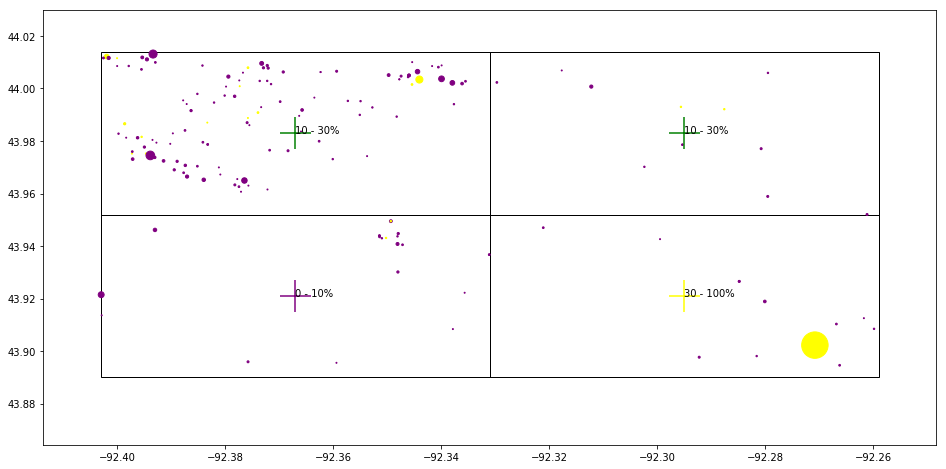

In [90]:
_df = df.loc[df.blat.cat.codes.isin(show_lat_codes) & df.blon.cat.codes.isin(show_lon_codes)].copy()
expand_interval(_df, 'blat')
expand_interval(_df, 'blon')
_, ax = plt.subplots(figsize=(16, 8))
c = _df.fai.map({False: frac_fai_colors[0], True: frac_fai_colors[-1]})
ax.scatter(_df.longitude, _df.latitude, s=_df.employees, c=c)

_dfb = dfb[dfb.blon_mid.isin(_df.blon_mid.unique()) & dfb.blat_mid.isin(_df.blat_mid.unique())]
c = _dfb.frac_fai_cat.cat.codes.map({k: v for k, v in enumerate(frac_fai_colors)})
ax.scatter(_dfb.blon_mid, _dfb.blat_mid, s=1000, marker='+', c=c)

for _, row in _dfb.iterrows():
    ax.annotate(row.frac_fai_cat, (row.blon_mid, row.blat_mid))
    r = mpl.patches.Rectangle(row[['blon_left', 'blat_left']], row.blon.length, row.blat.length, zorder=0, fill=False)
    ax.add_patch(r)

plt.plot()
_dfb

# CBSA
[Definition](https://www.census.gov/geo/reference/gtc/gtc_cbsa.html):
> **Core Based Statistical Areas (CBSAs)** consist of the county or counties or equivalent entities associated with at least one core (urbanized area or urban cluster) of at least 10,000 population, plus adjacent counties having a high degree of social and economic integration with the core as measured through commuting ties with the counties associated with the core.  The general concept of a CBSA is that of a core area containing a substantial population nucleus, together with adjacent communities having a high degree of economic and social integration with that core.  The term "core based statistical area" became effective in 2003 and refers collectively to metropolitan statistical areas and micropolitan statistical areas.

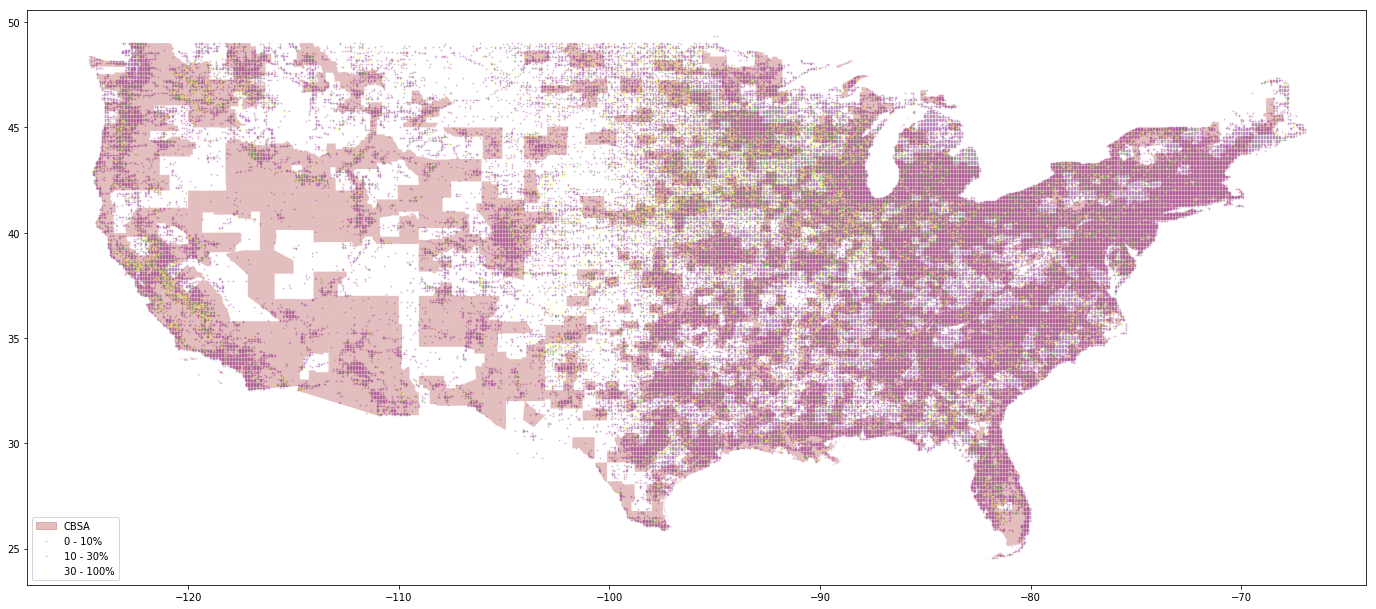

In [100]:
path_shp = './data/cbsa/cb_2017_us_cbsa_500k.shp'
gdf = gpd.read_file(path_shp)
gdf['state'] = gdf.NAME.str.extract(', (.+)$')[0]
gdf = gdf[~gdf.state.isin(excluded_states)]

ax = gdf.plot(figsize=(24, 100), **area_style)
area_legend = mpl.patches.Patch(**area_style)
for code, cat in enumerate(dfb.frac_fai_cat.cat.categories):
    _dfb = dfb[dfb.frac_fai_cat == cat]
    ax.scatter(_dfb.blon_mid, _dfb.blat_mid, s=1, c=frac_fai_colors[code], alpha=0.2, label=cat)
point_handles, point_labels = ax.get_legend_handles_labels()
ax.legend([area_legend, *point_handles], ['CBSA', *point_labels], loc='lower left')

# CSA
[Definition](https://www.census.gov/geo/reference/gtc/gtc_cbsa.html):
> **Combined Statistical Areas (CSAs)** consist of two or more adjacent CBSAs that have substantial employment interchange.  The CBSAs that combine to create a CSA retain separate identities within the larger CSA.  Because CSAs represent groupings of metropolitan and/or micropolitan statistical areas, they should not be ranked or compared with individual metropolitan and micropolitan statistical areas.

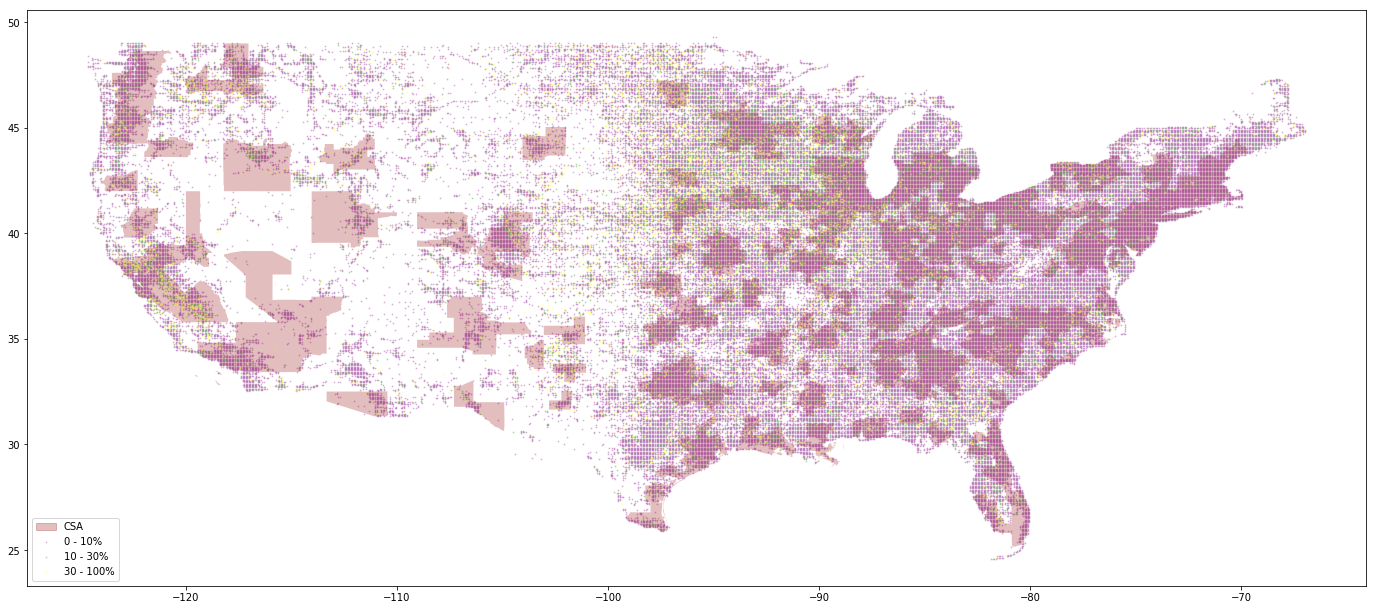

In [99]:
path_shp = './data/csa/cb_2017_us_csa_500k.shp'
gdf = gpd.read_file(path_shp)
gdf['state'] = gdf.NAME.str.extract(', (.+)$')[0]
gdf = gdf[~gdf.state.isin(excluded_states)]

ax = gdf.plot(figsize=(24, 100), **area_style)
area_legend = mpl.patches.Patch(**area_style)
for code, cat in enumerate(dfb.frac_fai_cat.cat.categories):
    _dfb = dfb[dfb.frac_fai_cat == cat]
    ax.scatter(_dfb.blon_mid, _dfb.blat_mid, s=1, c=frac_fai_colors[code], alpha=0.2, label=cat)
point_handles, point_labels = ax.get_legend_handles_labels()
ax.legend([area_legend, *point_handles], ['CSA', *point_labels], loc='lower left')